# Counterfactual Testing

#### Imports

In [2]:
%cd /users/jsolt/FourierNN
import os
import h5py
from omegaconf import OmegaConf

import numpy as np
import torch
from torch import nn, optim
from torchviz import make_dot

from regressors.cnn import cnn
from util.plotting import plot_cf_loss, plot_image_grid, plot_imgrid_with_overlay


/users/jsolt/FourierNN/myenv/lib64/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/oscar/home/jsolt/FourierNN


#### Define functions

In [3]:
class CounterfactualLoss(nn.Module):
    def __init__(self, alpha=1.0):
        super(CounterfactualLoss, self).__init__()
        self.alpha = alpha
    '''
    x' = g(z')
    y' = h(z')
    y = h(f(x))
    L = d_x{ g(z'), x } - d_y{ h(z'), h(f(x)) }
    '''
    def forward(self, y, y_prime, x, x_prime):
        return self.d_image(x_prime, x) + self.d_label(y_prime, y)

    '''
    Distance function for the image space. 
    We want to minimize this, i.e., find x' such that x'=g(z') is maximally similar to x.
    '''
    def d_image(self, x_prime, x):
        return ((x_prime - x)**2).mean()
    
    '''
    Distance function for the label space. 
    We want to maximize this, i.e., find x' such that y'=h(z') is maximally different from y=h(z)=h(f(x)).
    '''
    def d_label(self, y_prime, y):
        return -self.alpha*((y_prime - y)**2)




class XCorrCounterfactualLoss(CounterfactualLoss):
    def __init__(self, alpha=1.0, beta=1.0):
        super(XCorrCounterfactualLoss, self).__init__(alpha)
        self.beta = beta

    def calc_d_image(self, x_prime, x):
        self.mse = torch.abs(x_prime - x).mean()
        self.xcorr = self.corrcoef_loss(x_prime, x)
        return self.mse + self.xcorr
    
    def corrcoef_loss(self, input, target):    
        # Covariance
        X = torch.cat((input, target), dim=-2)
        X -= torch.mean(X, -1, keepdim=True)

        X_T = torch.transpose(X, -2, -1)
        c = torch.matmul(X, X_T) / (X.shape[-1] - 1)

        # Correlation Coefficient
        d = torch.diagonal(c, dim1=-1, dim2=-2)
        stddev = torch.sqrt(d)
        stddev = torch.where(stddev == 0, 1, stddev)
        c /= stddev[:,:,:,None]
        c /= stddev[:,:,None,:]

        # 1 - Cross-Correlation Diagonal
        ccd = 1-torch.diagonal(c, offset=c.shape[-1]//2, dim1=-1, dim2=-2)
        
        return self.beta*ccd.mean()

def get_model(model_cfg):
    # initialize model
    model = cnn(model_cfg)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Load model state
    path = f"{model_cfg.model.model_dir}/{model_cfg.model.name}"
    print(f"Loading model state from {path}...")
    checkpoint = torch.load(f"{path}.pth", map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])

    for param in model.parameters():
        param.requires_grad = False

    model.eval()

    return model

def get_sample(i, data_path, param_index, model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with h5py.File(data_path, "r") as f: 
        j = i % len(f['lightcones/brightness_temp'])
        x = torch.tensor(f['lightcones/brightness_temp'][j], dtype=torch.float)[None,:]
        y = model(x.to(device))
        label = f['lightcone_params/physparams'][j, param_index]
    return x, y, label




#### Initialize

In [4]:
# Globals
names = {
        "p21c":"cnn_v03_p21c_ws0.0_2025-02-28T12-28",
        "ctrpx":"cnn_v03_ctrpx_ws0.0_2025-02-28T12-28",
        "zreion":"cnn_v03_zreion_ws0.0_2025-02-28T12-32"
}

data_paths = {
    "ctrpx":"/users/jsolt/data/jsolt/centralpix_sims/centralpix05/centralpix05_norm_subdiv_sliced_ws0.0.hdf5",
    "zreion":"/users/jsolt/data/jsolt/zreion_sims/zreion24/zreion24_norm_subdiv_sliced_ws0.0.hdf5",
    "p21c":"/users/jsolt/data/jsolt/21cmFAST_sims/p21c14/p21c14_norm_subdiv_sliced_ws0.0.hdf5",
}

ids = {
        "p21c":"p21c_ws0.0",
        "ctrpx":"ctrpx_ws0.0",
        "zreion":"zreion_ws0.0"
}

sim = 'ctrpx'

id = ids[sim]
name = names[sim]

# PARAMS
cf_version = f"yprime_test"
n = 1
epochs = 10
alpha = 1.0
lr=0.01
init_weight = 0.001
mask=None

lci = 0

#### Load Model

In [5]:
# Load model config
model_cfg_path = f"trained_models/{id}/{name}/{name}_config.yaml" 
model_cfg = OmegaConf.load(model_cfg_path)

# Load model
model = get_model(model_cfg)


Loading model state from trained_models/ctrpx_ws0.0/cnn_v03_ctrpx_ws0.0_2025-02-28T12-28/cnn_v03_ctrpx_ws0.0_2025-02-28T12-28...


#### Load input data

In [6]:
x, y, y_true = get_sample(lci, data_paths[sim], model_cfg.data.param_index, model)

#### Generate Counterfactual

y=1.648


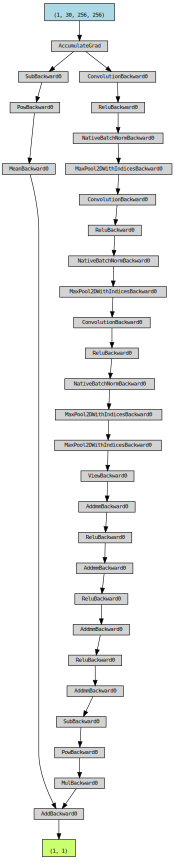

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

init = init_weight*torch.randn_like(x)
if mask != None: init*= mask
x_prime = init + x

x, x_prime = x.to(device), x_prime.to(device)
if mask != None: mask = mask.to(device)

x_prime.requires_grad = True
x.requires_grad = False
y.requires_grad = False
print(f"y={y.item():.3f}")

optimizer = optim.Adam([x_prime], lr=lr) 

lossfn = XCorrCounterfactualLoss(alpha=alpha)

y_prime = model(x_prime)
total_loss_e = lossfn(y, y_prime, x, x_prime)

make_dot(total_loss_e, params={'x_prime':torch.autograd.Variable(x_prime)})
